In [1]:
import dask.dataframe as dd
import numpy as np
import glob
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math

mesc_output_dir = "/gpfs/Labs/Uzun/SCRIPTS/PROJECTS/2024.SINGLE_CELL_GRN_INFERENCE.MOELLER/output/mESC"

parquet_paths = sorted(glob.glob(f"{mesc_output_dir}/*/inferred_grns/inferred_score_df.parquet"))

# go up two levels: parquet → inferred_grns dir → sample dir
network_name_list = [
    os.path.basename(os.path.dirname(os.path.dirname(p)))
    for p in parquet_paths
]

print(network_name_list)

# 4) Define your bin edges
n_bins = 50
bins = np.linspace(0,1,51)

['filtered_L2_E7.5_rep1', 'filtered_L2_E7.5_rep2', 'filtered_L2_E7.75_rep1', 'filtered_L2_E8.0_rep1', 'filtered_L2_E8.0_rep2', 'filtered_L2_E8.5_rep1', 'filtered_L2_E8.5_rep2', 'filtered_L2_E8.75_rep2']


In [2]:
def read_inferred_network_dask(inferred_network_file: str) -> dd.DataFrame:
    """
    Loads a melted sparse inferred network from Parquet and pivots it into a Dask DataFrame
    where each row is (source_id, target_id) and columns are score_types (mean-aggregated).
    """
    melted_ddf: dd.DataFrame = dd.read_parquet(inferred_network_file, engine="pyarrow")

    # Standardize IDs
    melted_ddf["source_id"] = melted_ddf["source_id"].str.upper()
    melted_ddf["target_id"] = melted_ddf["target_id"].str.upper()

    # Aggregate scores
    grouped_ddf = (
        melted_ddf
        .groupby(["source_id", "target_id", "score_type"])["score_value"]
        .mean()
        .reset_index()
    )

    # Pivot manually by converting to pandas (if dataset is small enough)
    def pivot_partition(df):
        return df.pivot_table(
            index=["source_id", "target_id"],
            columns="score_type",
            values="score_value",
            aggfunc="mean"
        ).reset_index()

    # Apply pivot in a single partition (best if you've already aggregated)
    pivot_df = grouped_ddf.compute()  # convert to Pandas here
    pivot_df = pivot_partition(pivot_df)
    return dd.from_pandas(pivot_df, npartitions=1)

In [ ]:
def compute_and_plot_histograms(
    sample_name,
    bins,
    features,
    axes,
    mesc_output_dir
):
    """
    Loads one network, computes per-feature histogram proportions
    using the fixed 'bins', and plots onto the provided axes.
    """
    # 1) Load & pivot
    path = os.path.join(
        mesc_output_dir,
        sample_name, "inferred_grns", "inferred_score_df.parquet"
    )
    ddf = read_inferred_network_dask(path)
    df  = ddf.compute()

    # 2) For each feature, compute and plot
    x_centers = 0.5 * (bins[:-1] + bins[1:])
    for j, feat in enumerate(features):
        counts, _ = np.histogram(df[feat].dropna(), bins=bins)
        prop = counts / counts.sum()
        ax = axes.flat[j]
        ax.plot(x_centers, prop, label=sample_name, alpha=0.7)
        ax.set_title(feat, fontsize=14)
        ax.set_xlabel("Score", fontsize=12)
        ax.set_ylabel("Proportion", fontsize=12)

Plotting for filtered_L2_E7.5_rep1
Plotting for filtered_L2_E7.5_rep2
Plotting for filtered_L2_E7.75_rep1
Plotting for filtered_L2_E8.0_rep1
Plotting for filtered_L2_E8.0_rep2
Plotting for filtered_L2_E8.5_rep1
Plotting for filtered_L2_E8.5_rep2
Plotting for filtered_L2_E8.75_rep2


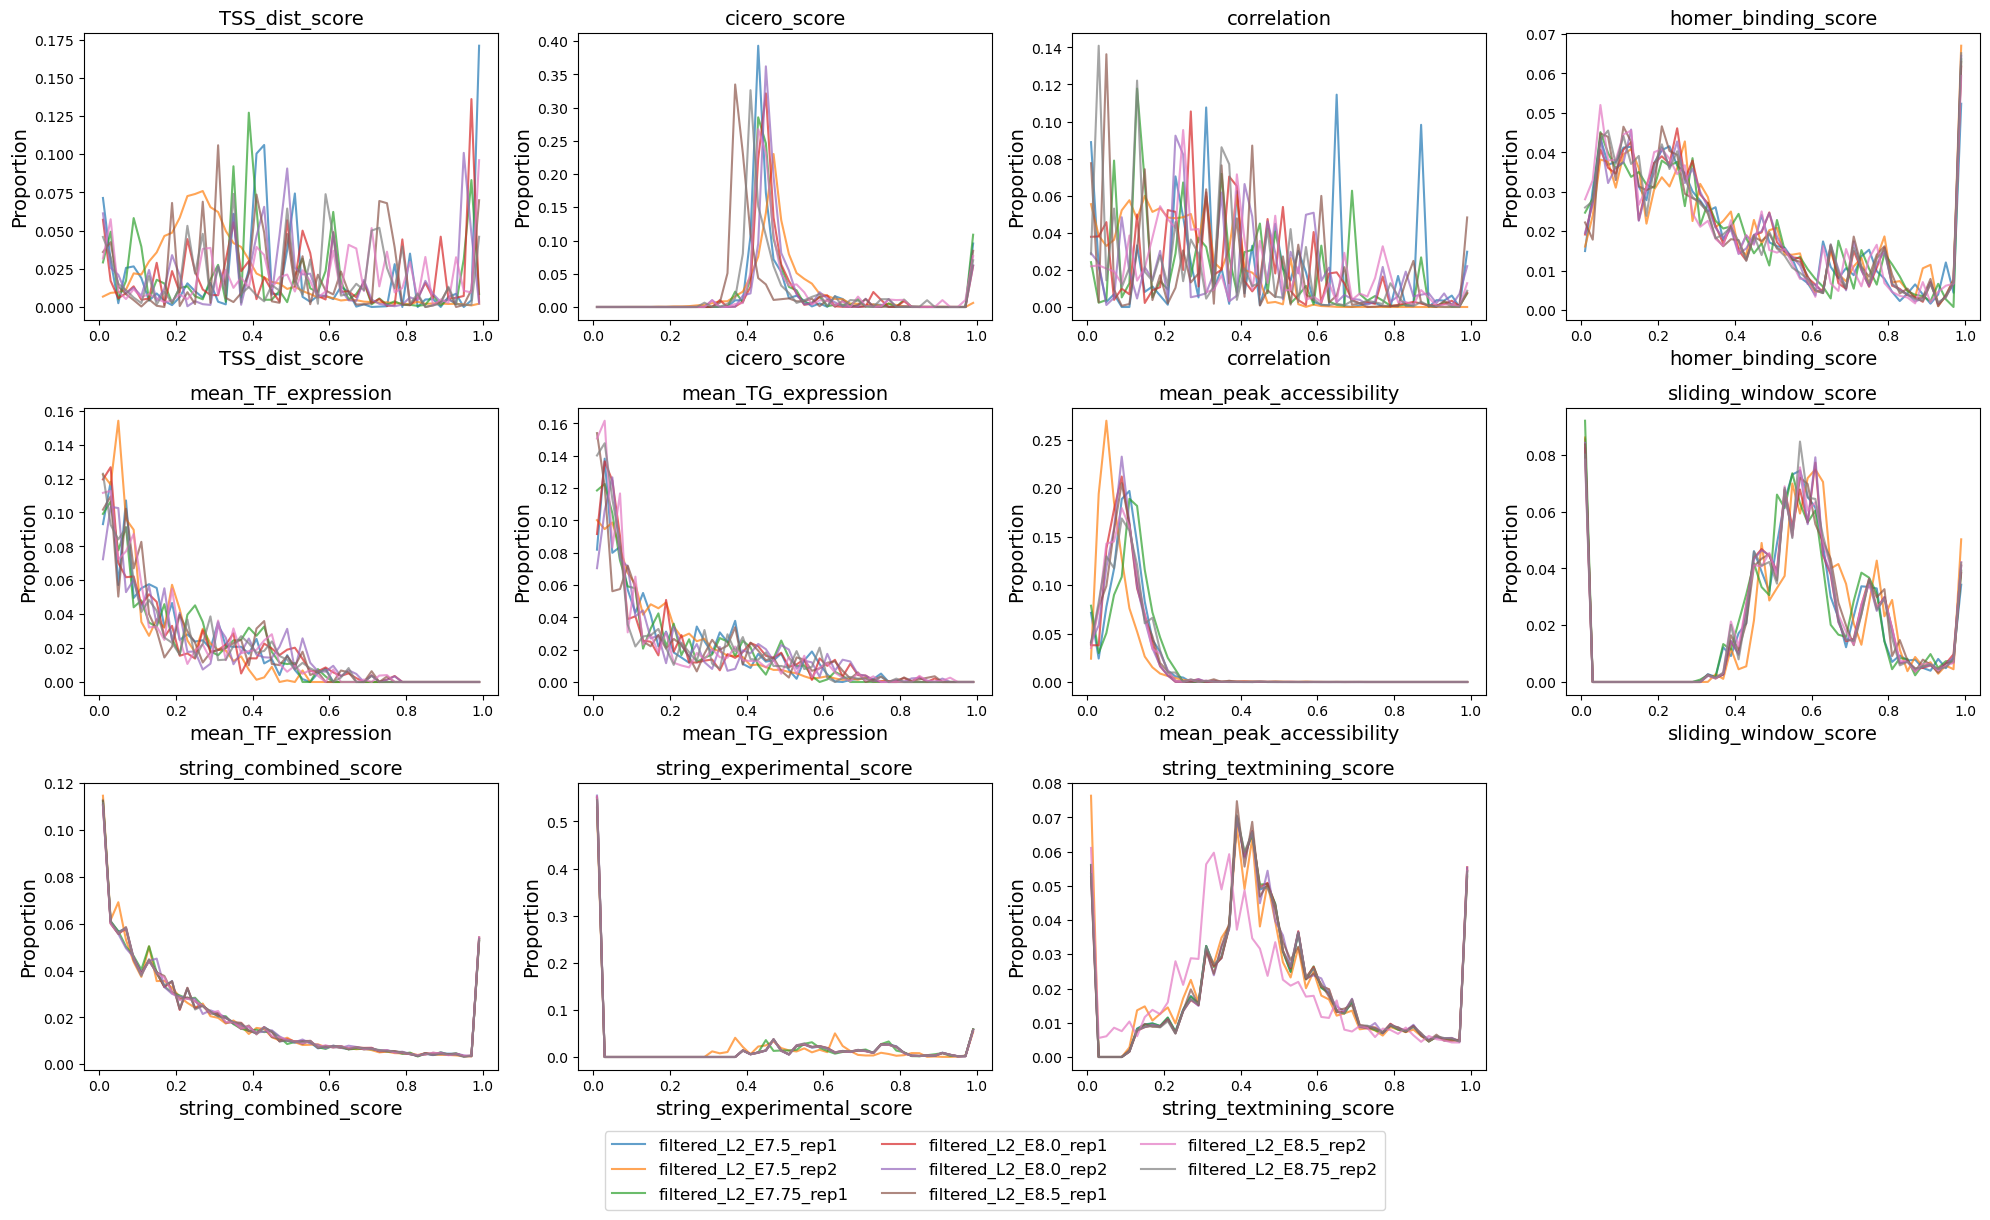

In [6]:
features = ['TSS_dist_score', 'cicero_score', 'correlation', 'homer_binding_score', 'mean_TF_expression', 'mean_TG_expression', 'mean_peak_accessibility', 'sliding_window_score', 'string_combined_score', 'string_experimental_score', 'string_textmining_score']

ncols = 4
nrows = math.ceil(len(features) / ncols)
fig, axes = plt.subplots(nrows, ncols, figsize=(5*ncols, 4*nrows), squeeze=False)

# One pass per sample, plotting onto the shared axes grid
for i, sample_name in enumerate(network_name_list):
    print(f'Plotting for {sample_name} ({i+1}/{len(network_name_list)})')
    compute_and_plot_histograms(
        sample_name,
        bins,
        features,
        axes,
        mesc_output_dir
    )
    
# hide the extra (12th) subplot
for ax in axes.flat[len(features):]:
    ax.set_visible(False)

# Common legend and layout
handles, labels = axes.flat[0].get_legend_handles_labels()
fig.legend(handles, labels,
           loc="lower center", ncol=3, fontsize=12,
           bbox_to_anchor=(0.5, -0.02))
fig.tight_layout(rect=[0, 0.05, 1, 1])
plt.show()